In [ ]:
import math
import collections
import torch
from torch import nn, Tensor
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

import timm
from PIL import Image
import os
import numpy as np
import json
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt

from tokenizer import BPETokenizer
import loralib as lora
import cv2
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def set_seed(seed):
    ''' set random seeds '''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        
set_seed(0)

# Data Augmentation
valid_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [2]:
class Config:

    def __init__(self, checkpoint=None):
        self.n_layer = 12
        self.n_head = 12
        self.n_embd = 768
        self.vocab_size = 50257
        self.block_size = 1024
        self.checkpoint = checkpoint

class Attention(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        # self.c_attn = nn.Linear(cfg.n_embd, 3 * cfg.n_embd)
        # self.c_proj = nn.Linear(cfg.n_embd, cfg.n_embd)

        # Lora
        # ================================================================================================ #
        self.c_attn = lora.MergedLinear(cfg.n_embd, 3 * cfg.n_embd, r=8, enable_lora=[True, False, True])
        self.c_proj = lora.Linear(cfg.n_embd, cfg.n_embd, r=8)
        # ================================================================================================ #

        self.n_head = cfg.n_head
        self.n_embd = cfg.n_embd
        size = cfg.block_size
        self.register_buffer('bias', torch.tril(torch.ones(size, size)).view(1, 1, size, size))

    def forward(self, x):
        B, T, C = x.size() # batch, context, embedding
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        return self.c_proj((att @ v).transpose(1, 2).contiguous().view(B, T, C))

class Adapter(nn.Module):
    # adding
    def __init__(self, cfg):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(cfg.n_embd, cfg.n_embd // 4),
            nn.ReLU(),
            nn.Linear(cfg.n_embd // 4, cfg.n_embd)
        )
        
    def forward(self, x):
        x = self.block(x)
        return x

class CrossAttention(nn.Module):
    # adding
    def __init__(self, cfg):
        super().__init__()
        self.img_attn = nn.Linear(cfg.n_embd, 2 * cfg.n_embd)
        self.caption_attn = nn.Linear(cfg.n_embd, cfg.n_embd)
        self.c_proj = nn.Linear(cfg.n_embd, cfg.n_embd)

        # Lora
        # ================================================================================================ #
        # self.img_attn = lora.MergedLinear(cfg.n_embd, 2 * cfg.n_embd, r=8, enable_lora=[True, True])
        # self.caption_attn = lora.Linear(cfg.n_embd, cfg.n_embd, r=8)
        # self.c_proj = lora.Linear(cfg.n_embd, cfg.n_embd, r=8)
        # ================================================================================================ #
        
        self.n_head = cfg.n_head
        self.n_embd = cfg.n_embd

    def forward(self, x_dec, x_enc):
        B_enc, N_enc, C_enc = x_enc.size() # batch, patch, embedding 
        B_dec, N_dec, C_dec = x_dec.size() # batch, context, embedding
        k_enc, v_enc  = self.img_attn(x_enc).split(self.n_embd, dim=2)
        q_dec = self.caption_attn(x_dec)
        
        # q from decoder; k,v from encoder
        k = k_enc.view(B_enc, N_enc, self.n_head, C_enc // self.n_head).transpose(1, 2)
        q = q_dec.view(B_dec, N_dec, self.n_head, C_dec // self.n_head).transpose(1, 2)
        v = v_enc.view(B_enc, N_enc, self.n_head, C_enc // self.n_head).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
#         att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))  # without masked
        att = F.softmax(att, dim=-1)
        return self.c_proj((att @ v).transpose(1, 2).contiguous().view(B_dec, N_dec, C_dec)), att

class Block(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.ln_1 = nn.LayerNorm(cfg.n_embd)
        self.ln_2 = nn.LayerNorm(cfg.n_embd)
        self.ln_3 = nn.LayerNorm(cfg.n_embd)
        self.attn = Attention(cfg)
        self.cross_attn = CrossAttention(cfg)  # adding
        # self.adapter = Adapter(cfg)  # adding
        # self.mlp = nn.Sequential(collections.OrderedDict([
        #     ('c_fc', nn.Linear(cfg.n_embd, 4 * cfg.n_embd)),
        #     ('act', nn.GELU(approximate='tanh')),
        #     ('c_proj', nn.Linear(4 * cfg.n_embd, cfg.n_embd))
        # ]))

        self.mlp = nn.Sequential(collections.OrderedDict([
            ('c_fc', lora.MergedLinear(cfg.n_embd, 4 * cfg.n_embd, r=8, enable_lora=[True, True, True, True])),
            ('act', nn.GELU(approximate='tanh')),
            ('c_proj', lora.MergedLinear(4 * cfg.n_embd, cfg.n_embd, r=8, enable_lora=[True, True, True, True]))
        ]))

    def forward(self, concat_x):
        
        x, x_enc, _ = concat_x
        # for adapter
        # x = x + self.adapter(self.attn(self.ln_1(x)))
        # qkv, att = self.cross_attn(self.ln_1(x), self.ln_3(x_enc))
        # x = x + self.adapter(qkv)
        # x = x + self.adapter(self.mlp(self.ln_2(x)))
        
        x = x + self.attn(self.ln_1(x))
        qkv, att = self.cross_attn(self.ln_1(x), self.ln_3(x_enc))
        x = x + qkv  # adding
        x = x + self.mlp(self.ln_2(x))
        concat_x = [x, x_enc, att]
        return concat_x

class Decoder(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.block_size = cfg.block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(cfg.vocab_size, cfg.n_embd),
            wpe = nn.Embedding(cfg.block_size, cfg.n_embd),
            h = nn.Sequential(*[Block(cfg) for _ in range(cfg.n_layer)]),
            ln_f = nn.LayerNorm(cfg.n_embd)
        ))
        self.lm_head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        # load checkpoint
        if self.cfg.checkpoint is not None:
            state_dict = torch.load(self.cfg.checkpoint)
            transposed = [ '.c_attn.weight', '.c_fc.weight', '.c_proj.weight' ]
            for key, value in state_dict.items():
                if any(key.endswith(w) for w in transposed):
                    state_dict[key] = value.t()
            self.transformer.load_state_dict(state_dict, strict=False)

    def forward(self, x: Tensor, x_enc):
        x = torch.narrow(x, 1, 0, min(x.size(1), self.block_size))
        pos = torch.arange(x.size()[1], dtype=torch.long, device=x.device).unsqueeze(0)
        x = self.transformer.wte(x) + self.transformer.wpe(pos)
        x, _, att = self.transformer.h([x, x_enc, 0])
        x = self.lm_head(self.transformer.ln_f(x))

        return x, att


In [3]:
class ImgDataset(Dataset):
    
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        
    def __getitem__(self, index):
        img_list = os.listdir(self.img_dir)
        img_path = os.path.join(self.img_dir, img_list[index])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        img_name = img_list[index].split('.')[0]

        return img, img_name

    def __len__(self):
        return len(os.listdir(self.img_dir))

In [4]:
class VLModel(nn.Module):
    
    def __init__(self, cfg, device):
        super().__init__()
        self.device = device
        self.vit = timm.create_model('vit_huge_patch14_clip_224.laion2b_ft_in12k_in1k', pretrained=True, num_classes=0).to(device)
        self.linear = nn.Linear(1280, 768)
        self.decoder = Decoder(cfg).to(device)
        
    def forward(self, image, caption):
        x_enc = self.vit.forward_features(image)
        x_enc = self.linear(x_enc)
        res, att = self.decoder(caption, x_enc)
        return res, att

In [5]:
def make_grid_plt(images, captions, save_path):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(5, 5, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 1])

    for i, (image_path, caption) in enumerate(zip(images, captions)):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = plt.subplot(gs[i])
        ax.imshow(img)
        ax.set_title(caption, fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    plt.close()

In [6]:
def generate(model, test_dir, json_file_path, save_dir, device):
    
    test_data = ImgDataset(test_dir, valid_tfm)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

    model.to(device)
    model.eval()
    
    encoding = BPETokenizer('./encoder.json', './vocab.bpe')

    prediction = {}
    
    # Start generating caption
    for batch in (test_loader):
        captions = []
        images = []

        count = 0
        img, img_name = batch
        img_name = img_name[0]
        
        with torch.no_grad():
            pred_token = [50256]

            while len(pred_token) <= 1 or pred_token[-1] != 50256:

                if len(pred_token) == 70:
                    break

                logits, att_map = model(img.to(device), torch.tensor(pred_token).unsqueeze(0).to(device))
                origin_img = cv2.imread(os.path.join(test_dir, img_name + '.jpg'))
                att_map = att_map.squeeze(0)[11]  # choose head
                new_att_map = att_map[-1, 1:].cpu()  # length = 257 - 1 (CLS)
                width = int(len(new_att_map) ** 0.5) # 256 = 14 * 14
                att_mask = new_att_map.reshape(width, width).numpy()
                # att_mask = att_mask / np.max(att_mask)
                att_mask = cv2.resize(att_mask, (origin_img.shape[1], origin_img.shape[0]))
                
                heatmap = None
                heatmap = cv2.normalize(att_mask, heatmap, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                # heatmap = att_mask * 255
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                result = cv2.addWeighted(heatmap, 0.5, origin_img, 0.5, 0)
                save_img_name = str(count) + '_' + img_name + '.jpg'
                cv2.imwrite(os.path.join(save_dir, save_img_name), result)
                images.append(os.path.join(save_dir, save_img_name))

                prob = F.softmax(logits[:, -1, :], dim=-1)
                pred = torch.argmax(prob, dim=-1).view(-1).tolist()[-1]
                pred_token.append(pred)
                
                caption = encoding.decode(pred_token)
                caption = caption.replace('<|endoftext|>', '')
                # print(caption)
                tokens = re.findall(r"""<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d| ?""" +
                            r"""\w+| ?\d+| ?[^\s\w\d]+|\s+(?!\S)|\s+""", caption, re.UNICODE)
                # print(tokens)
                captions.append(tokens[-1])
                count += 1
            
            pred_caption = encoding.decode(pred_token)
            pred_caption = pred_caption.replace('<|endoftext|>', '')
            prediction[str(img_name)] = pred_caption
    
        images.insert(0, os.path.join(test_dir, img_name + '.jpg'))
        captions.insert(0, '<|endoftext|>')
        captions.insert(-1, '<|endoftext|>')

        make_grid_plt(images, captions, f'{save_dir}/{img_name}.jpg')
    
    with open(json_file_path, 'w') as json_file:
        json.dump(prediction, json_file)

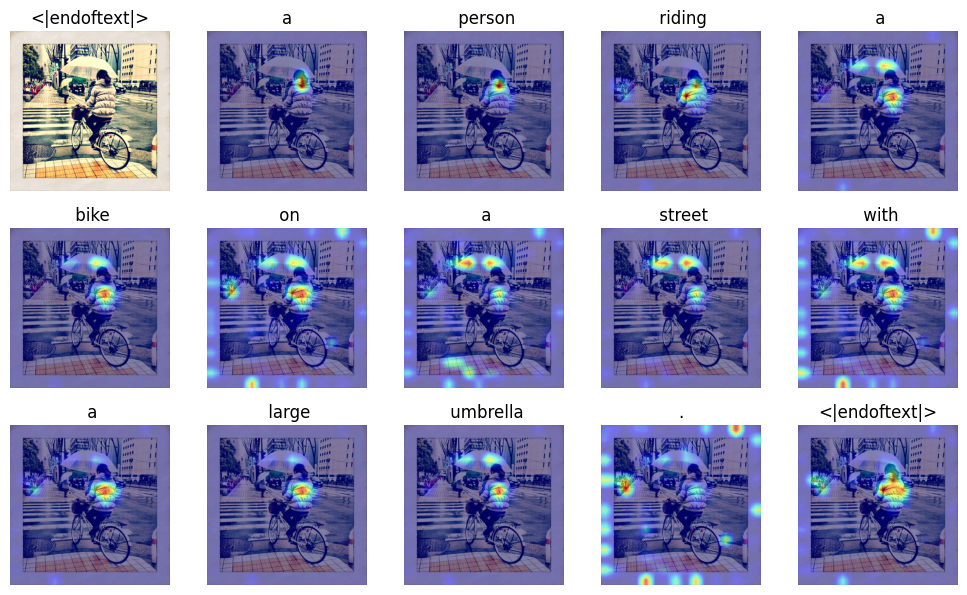

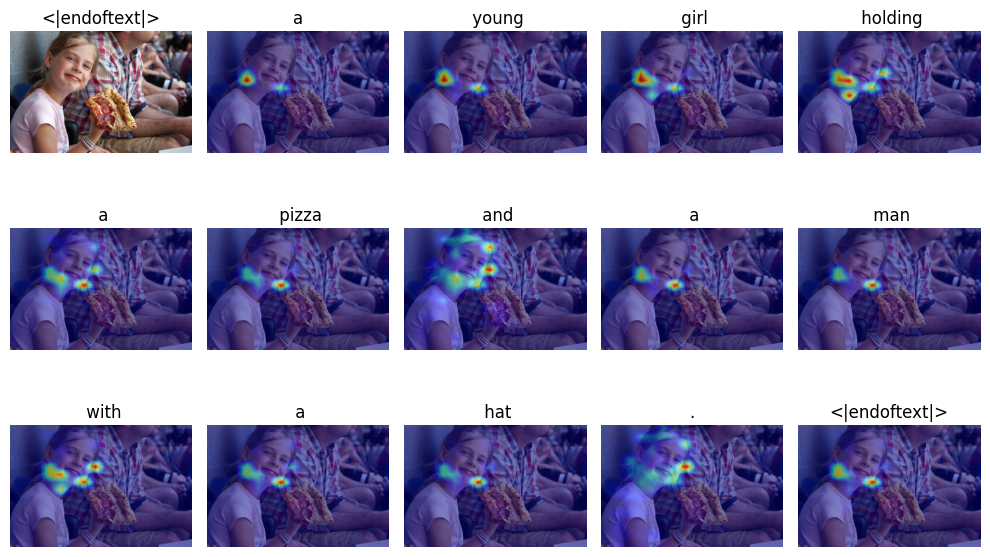

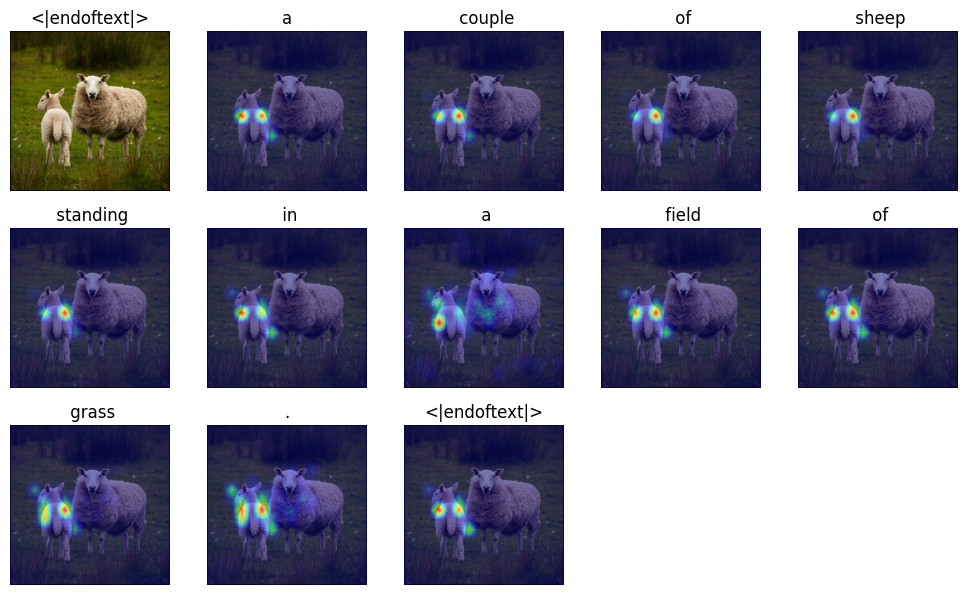

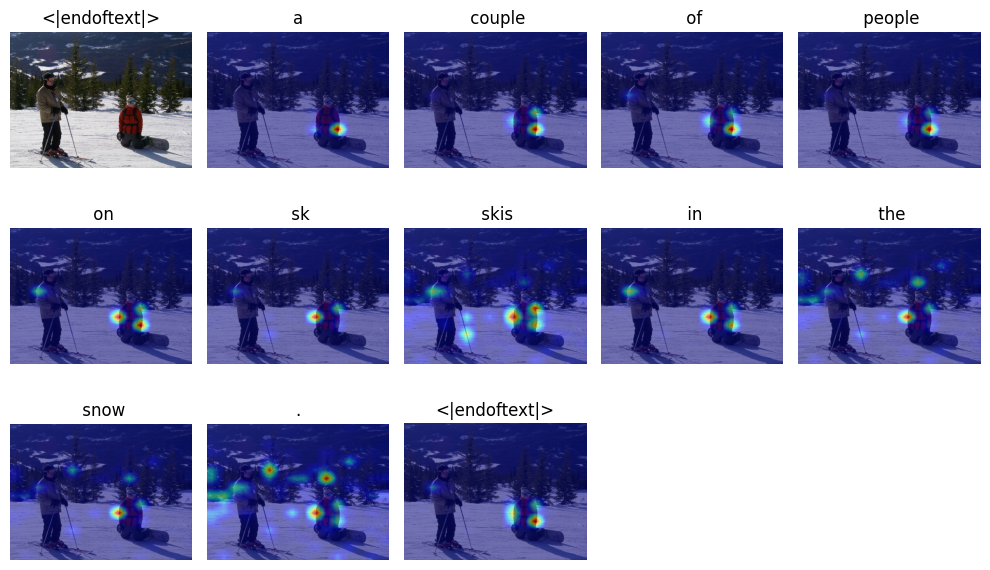

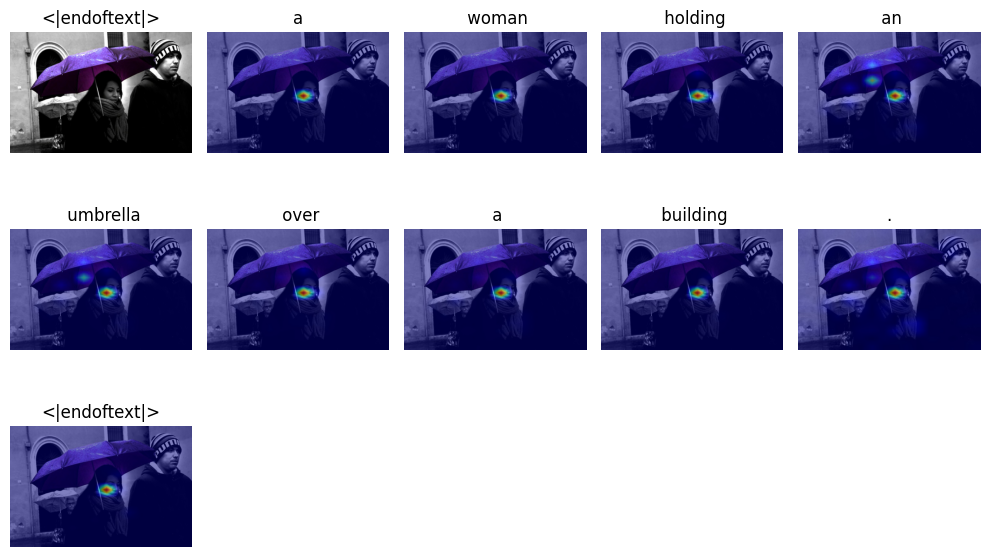

In [7]:
if __name__ == '__main__':
    
    decoder_ckpt = './hw3_data/p2_data/decoder_model.bin'
    valid_dir = './hw3_data/p2_data/images/val'
    test_dir = './hw3_data/p3_data/images'  # p3_data/images or top_last
    save_dir = './p3_result'
    json_file_path = './p3_result/p3_pred.json'

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    decoder_cfg = Config(checkpoint=decoder_ckpt)
    vl_model = VLModel(cfg=decoder_cfg, device=device)
    vl_model.load_state_dict(torch.load('./best_vl_model_huge_lora.pth'), strict=False)

    generate(
        model = vl_model,
        test_dir = test_dir, 
        json_file_path = json_file_path,
        save_dir = save_dir,
        device = device
    )

